In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [107]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.plotly as py
plt.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm
from geopy.geocoders import Nominatim
import seaborn as sns
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [3]:
data = pd.read_csv('Dyadic_COW_4.0.csv')
data = data.iloc[:,2:7]
data.head()

,year,importer1,importer2,flow1,flow2
0,1920,United States of America,Canada,611.85999,735.47998
1,1921,United States of America,Canada,335.44000,442.98999
2,1922,United States of America,Canada,364.01999,502.84000
3,1923,United States of America,Canada,416.00000,598.14001
4,1924,United States of America,Canada,399.14001,496.32001


Now, a first step is to reshape the data so that the flow2 column is below flow 1.

In [4]:
# Data flow1
data_flow_1 = data.loc[:, ['year', 'importer1', 'importer2', 'flow1']]
data_flow_2 = data.loc[:, ['year', 'importer1', 'importer2', 'flow2']]
data_flow_1.columns = ['year', 'Country_A', 'Country_B', 'flow']
data_flow_2.columns = ['year', 'Country_B', 'Country_A', 'flow']
# Dataset in good shape
df = pd.concat([data_flow_1, data_flow_2]).sort_index().reset_index(drop=True)
# Replace -9 by NaN
df = df.replace({'flow': {-9: np.nan}})
df.head()

,Country_A,Country_B,flow,year
0,United States of America,Canada,611.85999,1920
1,Canada,United States of America,735.47998,1920
2,United States of America,Canada,335.44000,1921
3,Canada,United States of America,442.98999,1921
4,United States of America,Canada,364.01999,1922


The flow represents the imports of Country_A from Country_B, in US millions of current dollars.

### Descriptive statistics about the evolution of the network

In [5]:
n_nodes = []
n_edges = []
for i in range(1950,2015):
    data_more_1950 = df.loc[np.where(df.year==i)[0], :]
    n_nodes.append(data_more_1950['Country_A'].nunique())
    n_edges.append(len(data_more_1950))

In [6]:
df_resume = pd.DataFrame({'year':[i for i in range(1950,2015)], 'Nb_nodes': n_nodes, 'Nb_edges':n_edges})

Text(0,0.5,'Number of nodes')

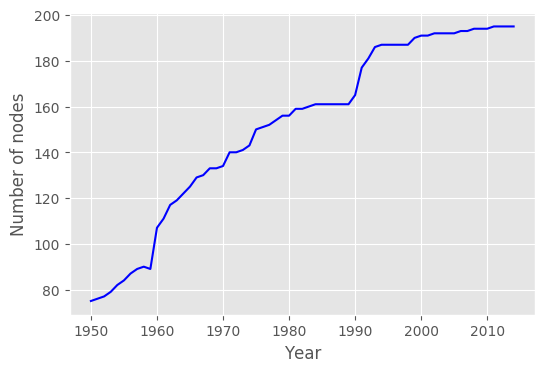

In [7]:
plt.plot(df_resume.year, df_resume.Nb_nodes, c = 'blue')
plt.xlabel('Year')
plt.ylabel('Number of nodes')

The number of country in the network increases.

Text(0,0.5,'Number of edges')

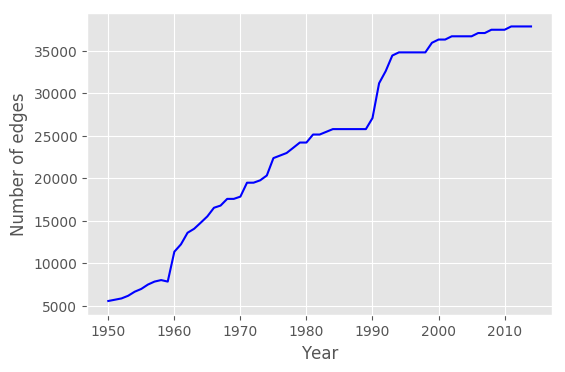

In [8]:
plt.plot(df_resume.year, df_resume.Nb_edges, c = 'blue')
plt.xlabel('Year')
plt.ylabel('Number of edges')

The number of exchanges increases.

Text(0,0.5,'Number of exchanges per country')

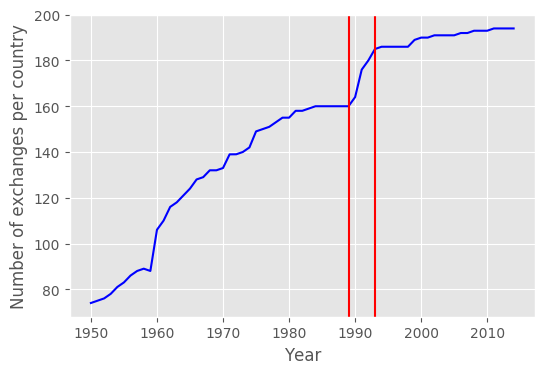

In [9]:
plt.plot(df_resume.year, df_resume.Nb_edges / df_resume.Nb_nodes, c = 'blue')
plt.axvline(x=1989, c = 'red')
plt.axvline(x=1993, c = 'red')
plt.xlabel('Year')
plt.ylabel('Number of exchanges per country')

The number of relation per country increases.

We can notice a drop in the years 1991-1993. It can come from the explosion of URSS. I will verify it.

In [10]:
lost_countries = list(set(df.loc[np.where(df.year==1989)[0],:].Country_A) - 
                      set(df.loc[np.where(df.year==1993)[0],:].Country_A))
new_countries = list(set(df.loc[np.where(df.year==1993)[0],:].Country_A) - 
                      set(df.loc[np.where(df.year==1989)[0],:].Country_A))

In [11]:
geolocator = Nominatim()
# Get coordinated of new countries
coordinates_new_countries = []
for i in new_countries:
    try:
        location = geolocator.geocode(i)
        coordinates_new_countries.append((location.latitude, location.longitude))
    except:
        coordinates_new_countries.append(('lat not found', 'lon not found'))
# Get coordinated of lost countries
coordinates_lost_countries = []
for i in lost_countries:
    try:
        location = geolocator.geocode(i)
        coordinates_lost_countries.append((location.latitude, location.longitude))
    except:
        coordinates_lost_countries.append(('lat not found', 'lon not found'))

In [12]:
df = pd.DataFrame({'Name': new_countries, 'lat': [i[0] for i in coordinates_new_countries], 'long': [i[1] for i in coordinates_new_countries]})

In [13]:
data = [ dict(
        type = 'scattergeo',
        lon = df['long'],
        lat = df['lat'],
        text = df['Name'],
        mode = 'markers',
        marker = dict(
            size = 3,
            opacity = 1,
            reversescale = True,
            autocolorscale = False,
            symbol = 'square',
            color='red'
        ))]

layout = dict(
        title = 'New countries between 1989 and 1993',
        colorbar = True,
        geo = dict(
            scope = 'europe',
            projection=dict( type='mollweide' ),
            showland = True,
            landcolor = "rgb(250, 250, 250)",
            subunitcolor = "rgb(217, 217, 217)",
            countrycolor = "rgb(217, 217, 217)",
            countrywidth = 0.5,
            subunitwidth = 0.5
        ),
    )

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False)

### Compute the evolution of the similarity between similarity matrices over time

In [223]:
data = pd.read_csv('Dyadic_COW_4.0.csv')
data = data.iloc[:,2:7]
data.head()

,year,importer1,importer2,flow1,flow2
0,1920,United States of America,Canada,611.85999,735.47998
1,1921,United States of America,Canada,335.44000,442.98999
2,1922,United States of America,Canada,364.01999,502.84000
3,1923,United States of America,Canada,416.00000,598.14001
4,1924,United States of America,Canada,399.14001,496.32001


In [228]:
# Data flow1
data_flow_1 = data.loc[:, ['year', 'importer1', 'importer2', 'flow1']]
data_flow_2 = data.loc[:, ['year', 'importer1', 'importer2', 'flow2']]
data_flow_1.columns = ['year', 'Country_A', 'Country_B', 'flow']
data_flow_1['key'] = data_flow_1['Country_A'] + '-' + data_flow_1['Country_B']
data_flow_2.columns = ['year', 'Country_B', 'Country_A', 'flow']
data_flow_2['key'] = data_flow_2['Country_B'] + '-' + data_flow_2['Country_A']
# Dataset in good shape
df = pd.concat([data_flow_1, data_flow_2]).sort_index().reset_index(drop=True)
# Replace -9 by NaN
df = df.replace({'flow': {-9: np.nan}})
# drop nan
df = df.dropna()
# We keep years from 1950
df = df[df.year>=1950].reset_index(drop=True)

In [234]:
# This gives us the proportion of importation of Country_A from Country_B at for each yer
df['flow'] = df['flow'] / df.groupby(['year', 'Country_A'])['flow'].transform(sum) * 100
# drop nan
df = df.dropna().reset_index(drop=True)

Here, we delete countries for which we do not know the value of their import.

For each year, we compute squared symmetric average exchanges' intensity matrix.

In [246]:
list_intensity_matrix = []
for i in list(df.year.unique()):
    inter_df = df[df.year==i]
    # Get squared similarity matrix
    list_intensity_matrix.append(pd.pivot_table(inter_df, values='flow', index=['Country_A'], columns=['Country_B'], fill_value=0))

In [249]:
diff_frobenius_norm = []
for i in range(len(list_intensity_matrix)-1):
    aligned_mat_left = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[0].as_matrix()
    aligned_mat_right = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[1].as_matrix()
    diff_frobenius_norm.append(np.linalg.norm(aligned_mat_left-aligned_mat_right, 'fro'))

__Bollinger bands method__

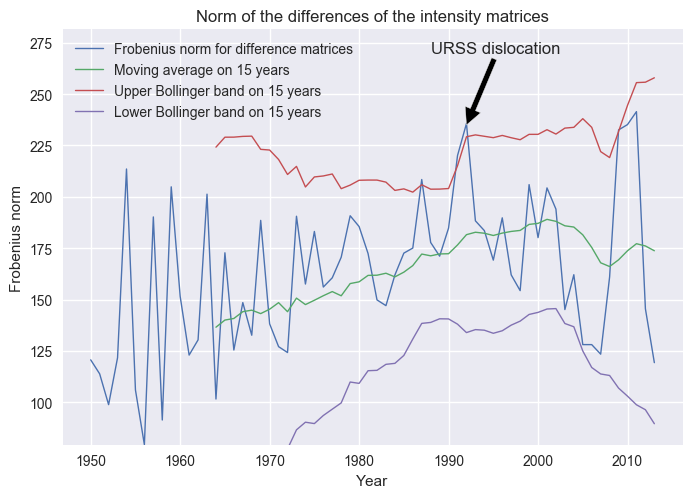

In [285]:
window_size = 15

ma_y = pd.Series(diff_frobenius_norm).rolling(window=window_size).mean()
std_y = pd.Series(diff_frobenius_norm).rolling(window=window_size).std()
Bollinger_dict = {'MA_y': ma_y, 'UB_y': ma_y+1.96*std_y, 'LB_y': ma_y-1.96*std_y}

fig = plt.figure()
ax = fig.add_subplot(111)

line, = ax.plot(list(df.year.unique())[:-1], diff_frobenius_norm, lw=1)
line, = ax.plot(list(df.year.unique())[:-1], Bollinger_dict['MA_y'], lw=1)
line, = ax.plot(list(df.year.unique())[:-1], Bollinger_dict['UB_y'], lw=1)
line, = ax.plot(list(df.year.unique())[:-1], Bollinger_dict['LB_y'], lw=1)

ax.annotate('URSS dislocation', xy=(1992, 235), xytext=(1988, 270),
            arrowprops=dict(facecolor='black'),)
ax.set_ylim(min(diff_frobenius_norm),max(diff_frobenius_norm)+40)
plt.title('Norm of the differences of the intensity matrices')
plt.xlabel('Year')
plt.ylabel('Frobenius norm')
plt.legend(loc = 'upper left', labels = ['Frobenius norm for difference matrices',
                                         'Moving average on {} years'.format(window_size),
                                         'Upper Bollinger band on {} years'.format(window_size),
                                         'Lower Bollinger band on {} years'.format(window_size)])

In [298]:
from itertools import compress
'The years where values of the norm are greater than the upper Bollinger band are {}'.format(
    list(compress(list(df.year.unique())[:-1], list(diff_frobenius_norm > Bollinger_dict['UB_y']))))

'The years where values of the norm are greater than the upper Bollinger band are [1987, 1991, 1992, 2009]'

__Twitter detection anomalie method__ <-- NOT WORKING FOR OUR PROBLEM

In [389]:
from pyculiarity import detect_ts
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.style.use('ggplot')

In [475]:
twitter_example_data = pd.read_csv('raw_data.csv', usecols=['timestamp', 'count'])
twitter_example_data.timestamp = twitter_example_data.timestamp.apply(lambda x: time.mktime(datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S").timetuple()))

/Users/Linger/anaconda/lib/python3.5/site-packages/pyculiarity/detect_anoms.py:81: FutureWarning:

convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.



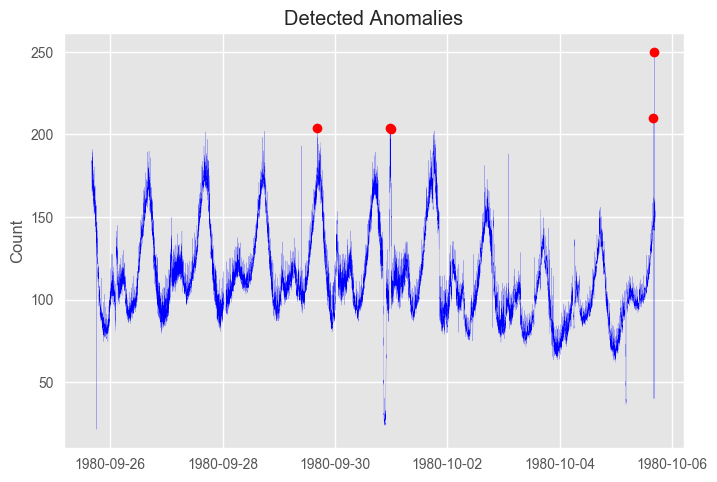

In [476]:
# first run the models
results = detect_ts(twitter_example_data, max_anoms=0.1, alpha=0.1, direction='both')

# format the twitter data nicely
twitter_example_data['timestamp'] = pd.to_datetime(twitter_example_data['timestamp'])
twitter_example_data.set_index('timestamp', drop=True)

# make a nice plot
f, ax = plt.subplots(1, 1, sharex=True)
ax.plot(twitter_example_data['timestamp'], twitter_example_data['count'], 'b', lw=0.1)
ax.plot(results['anoms'].index, results['anoms']['anoms'], 'ro')
ax.set_title('Detected Anomalies')
ax.set_ylabel('Count')
plt.show()

__Other method here__

In [477]:
import pickdetect

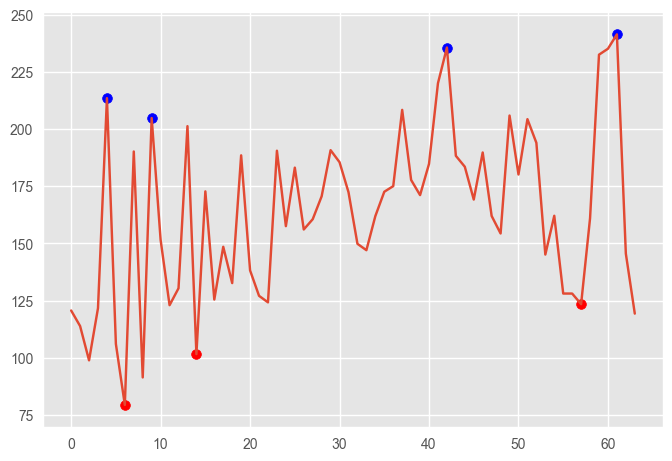

In [488]:
from matplotlib.pyplot import plot, scatter, show
series = diff_frobenius_norm
maxtab, mintab = pickdetect.peakdet(series,100)
plot(series)
scatter(np.array(maxtab)[:,0], np.array(maxtab)[:,1], color='blue')
scatter(np.array(mintab)[:,0], np.array(mintab)[:,1], color='red')
show()

We saw from the graphs of the evolution of the the nodes that the big change in 1991 comes from the URSS's dislocation. Indeed, a lot of new countries emerged, which multiplied exchanges, changing the structure of the world trade.

/Users/Linger/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



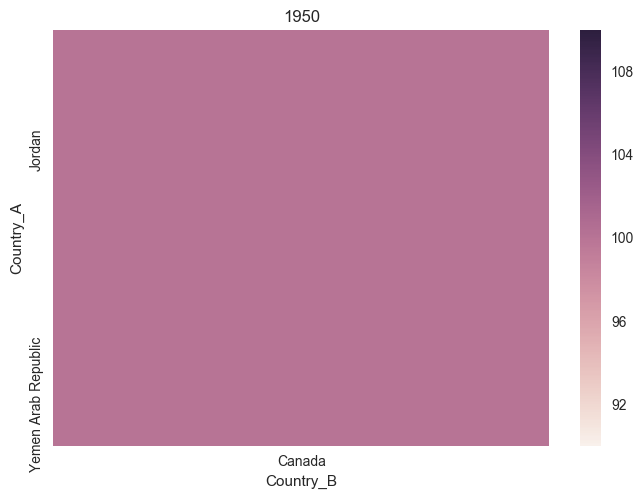

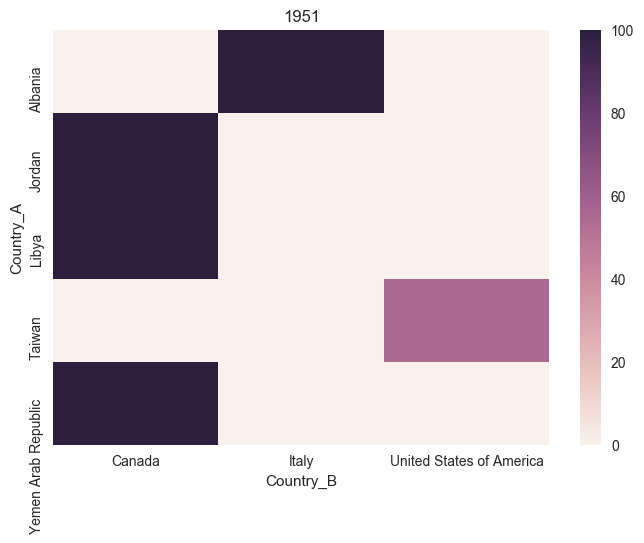

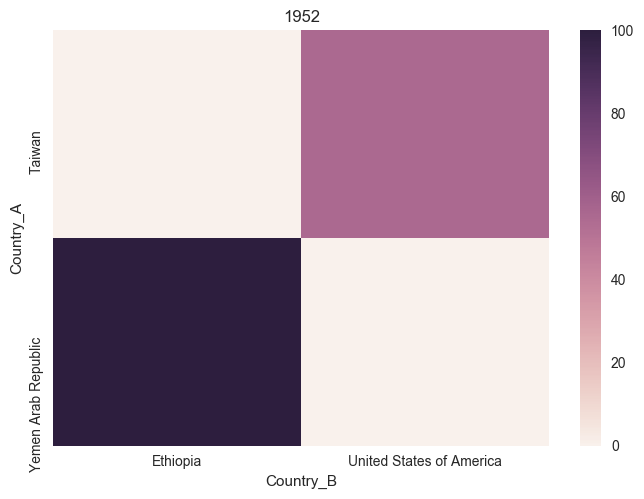

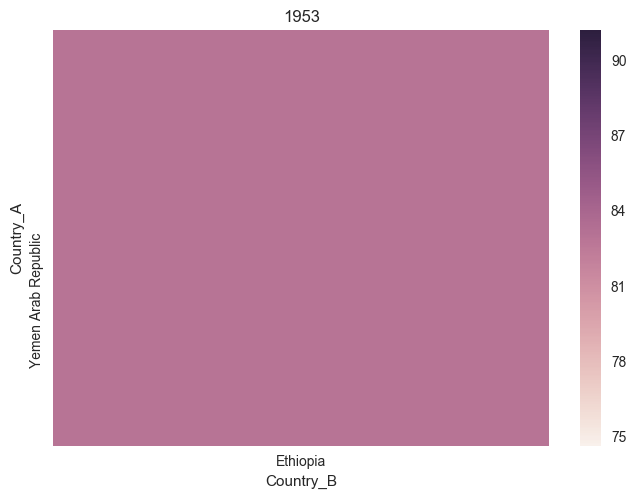

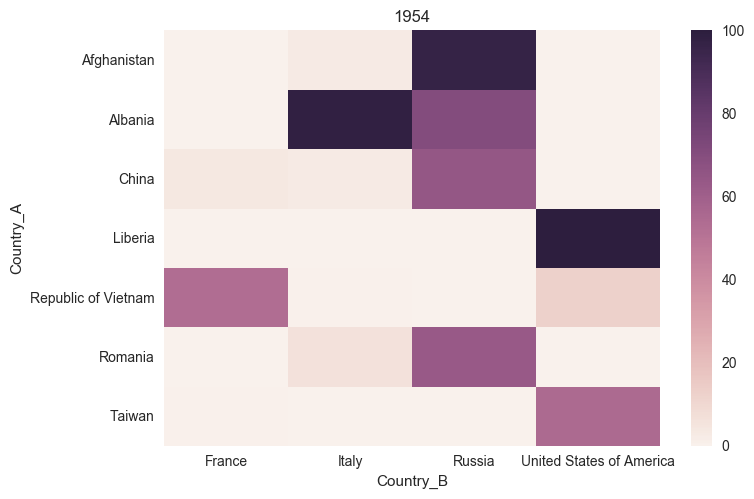

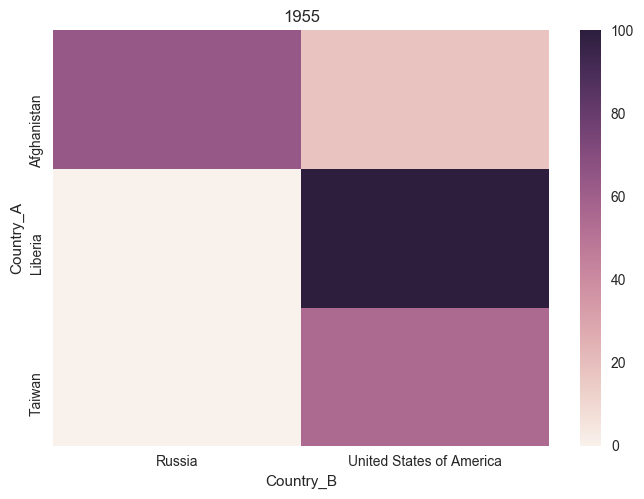

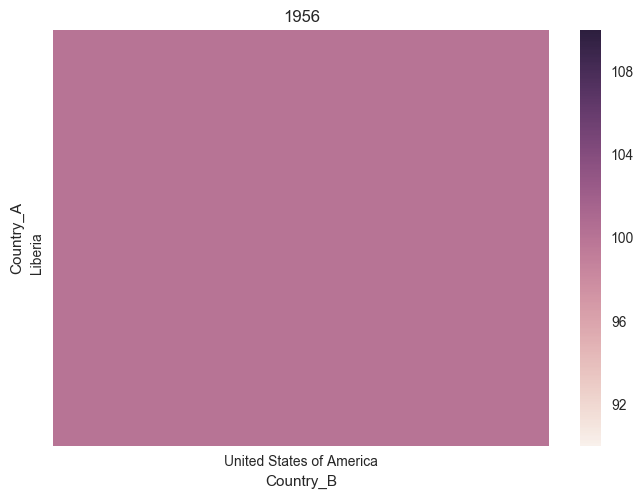

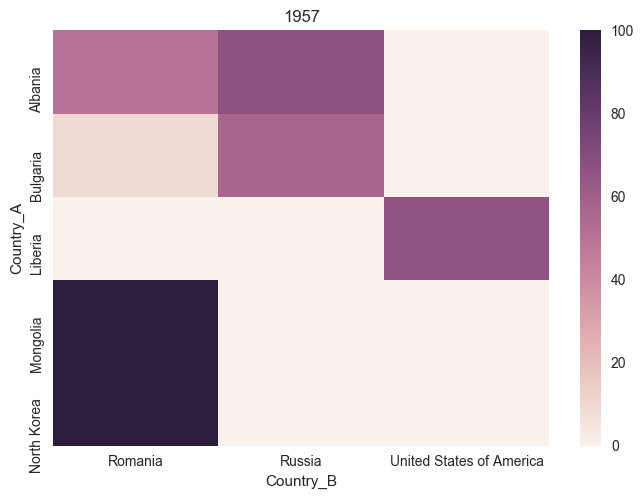

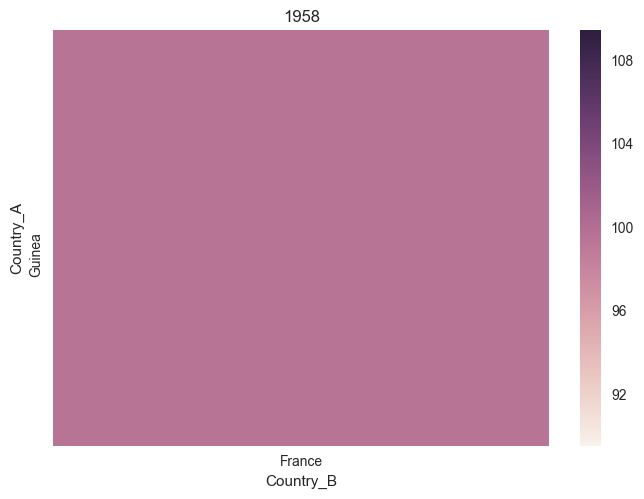

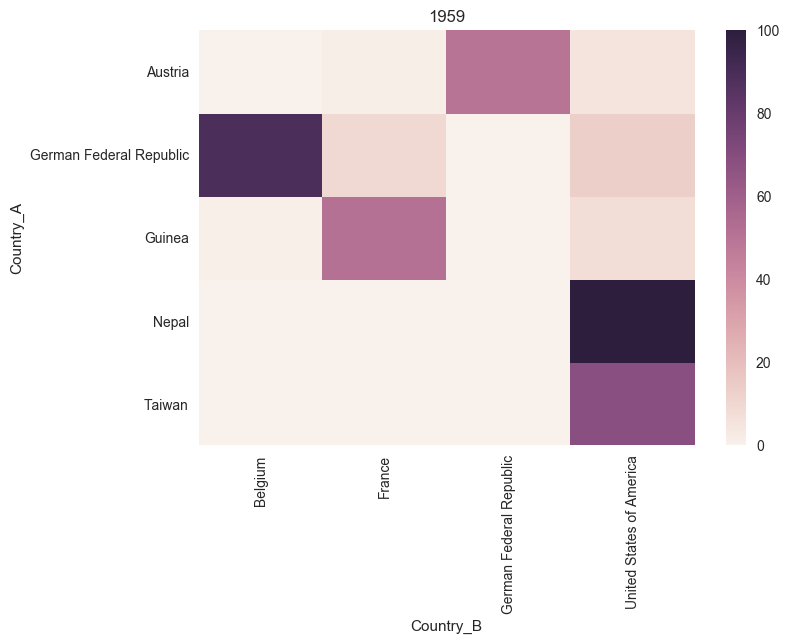

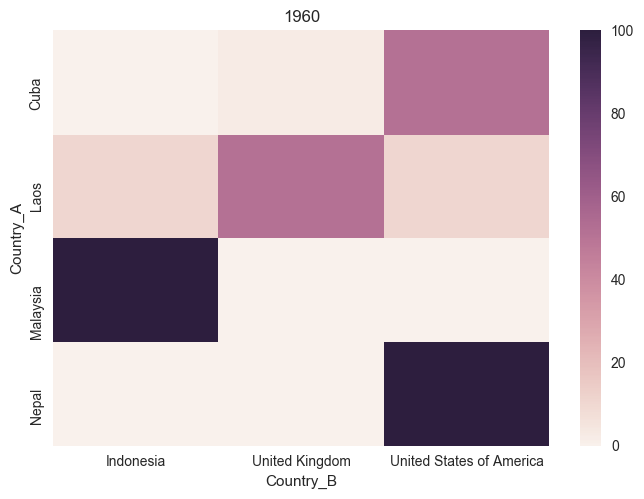

<Figure size 800x550 with 0 Axes>

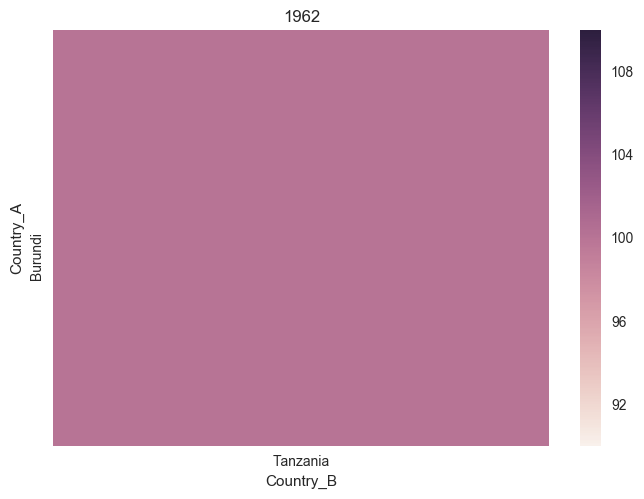

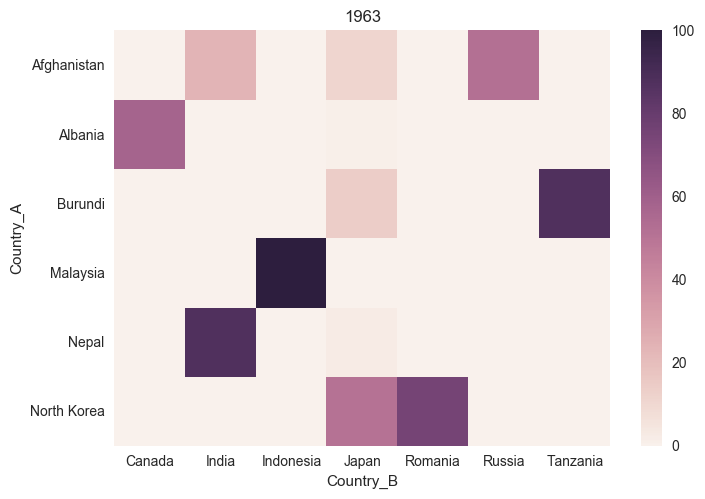

<Figure size 800x550 with 0 Axes>

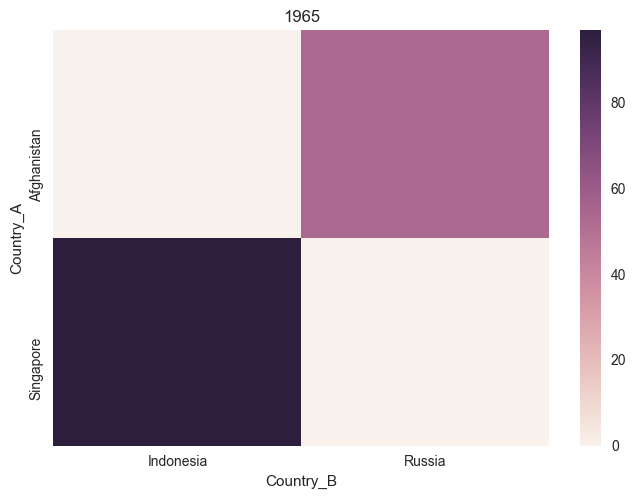

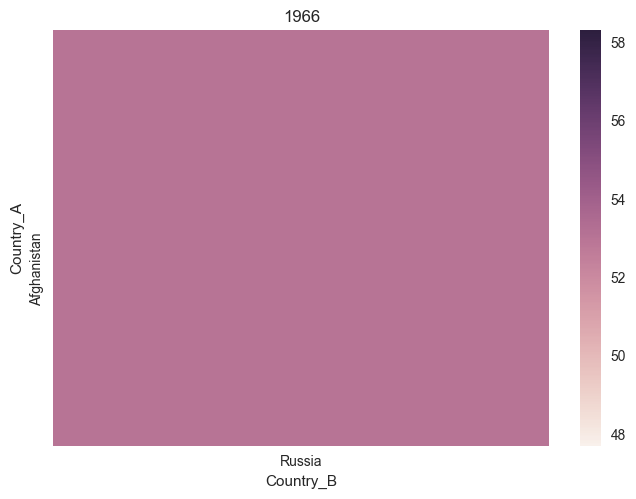

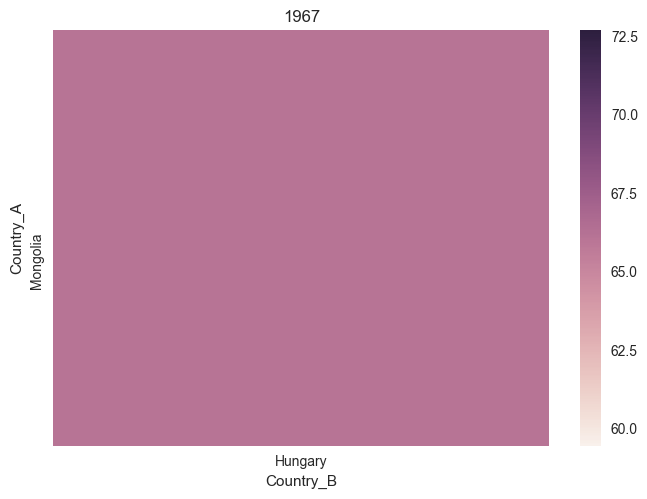

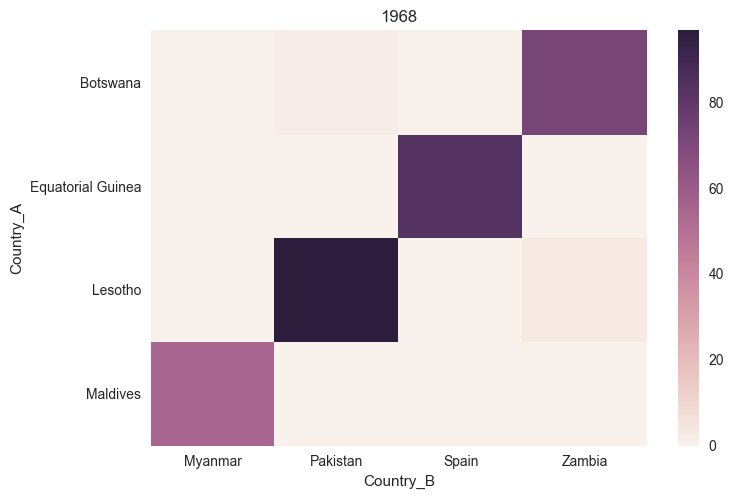

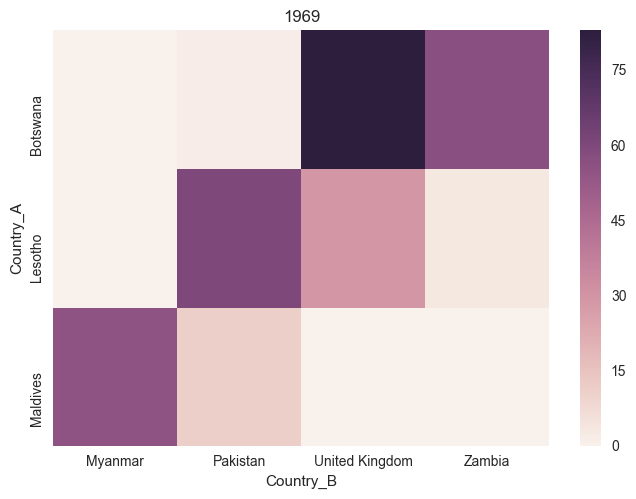

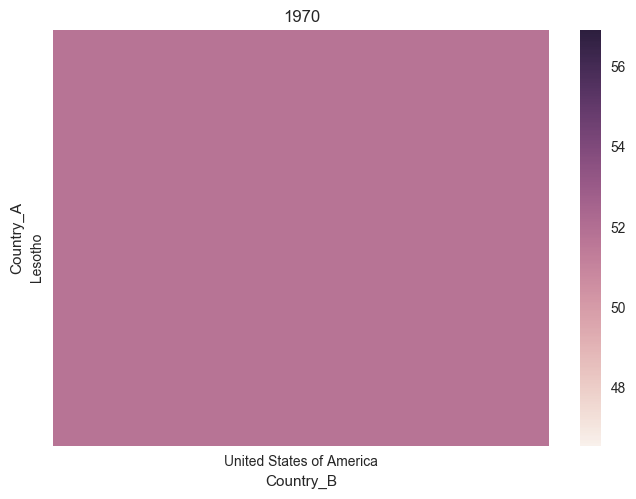

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

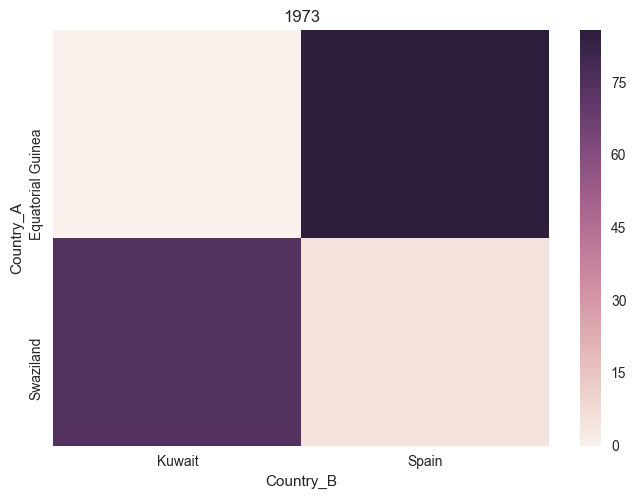

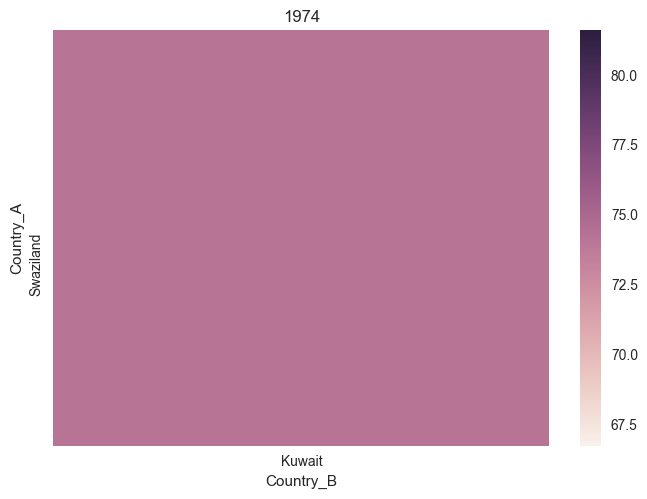

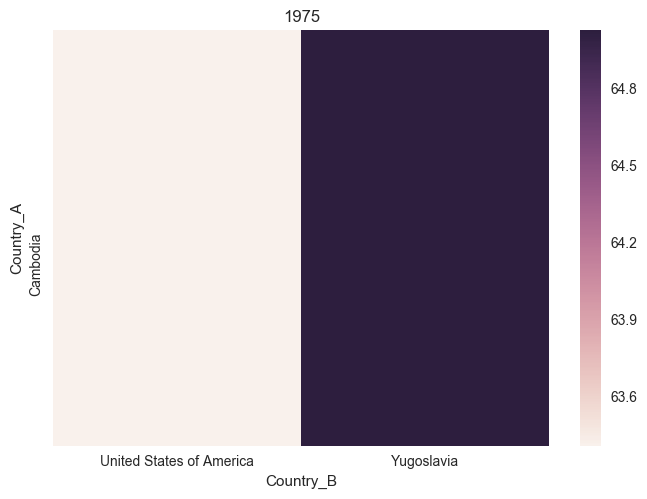

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

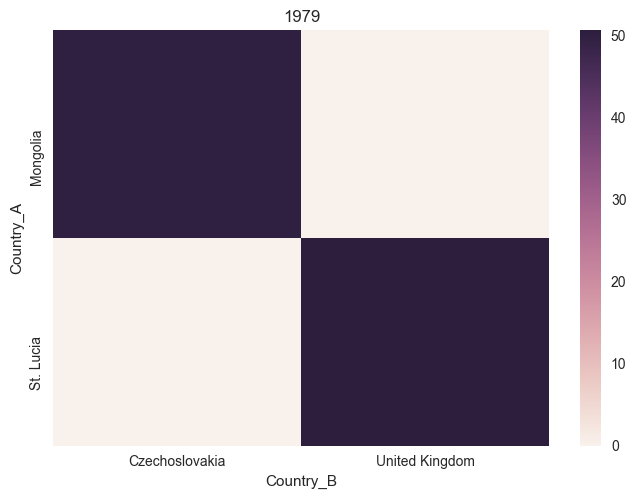

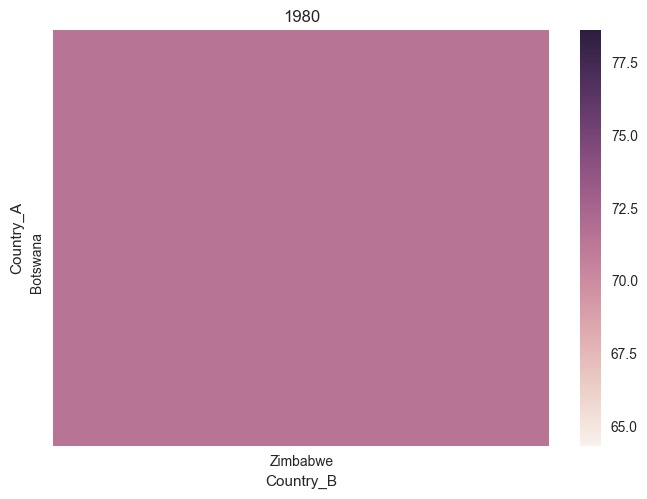

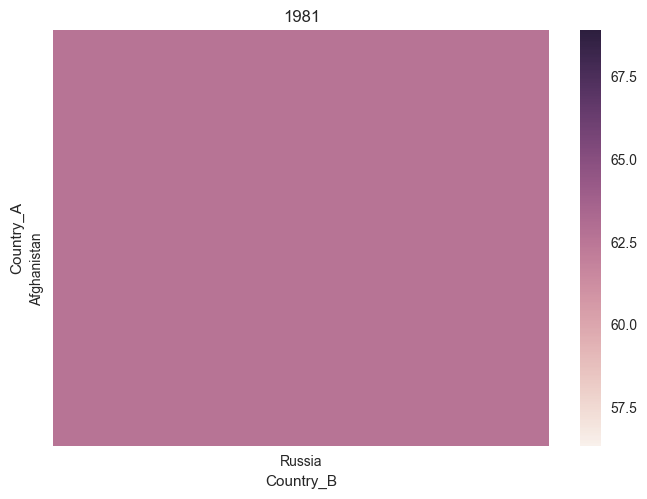

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

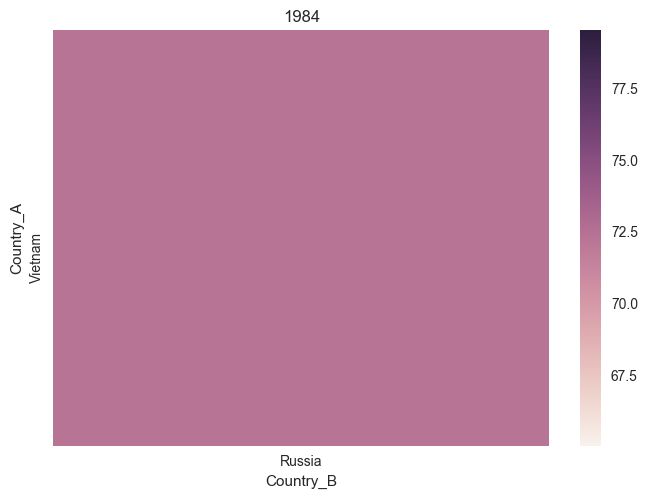

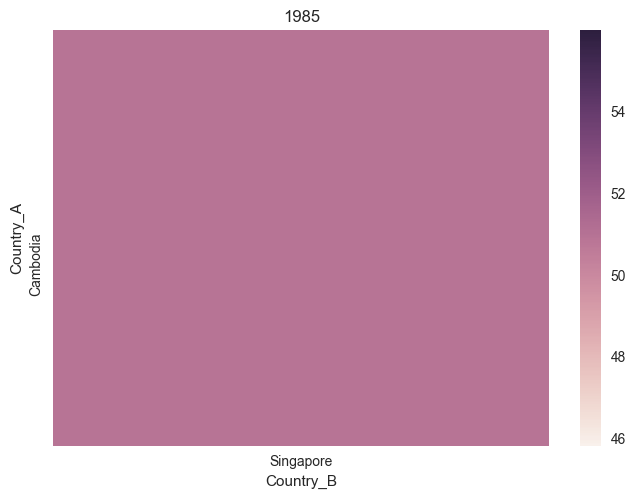

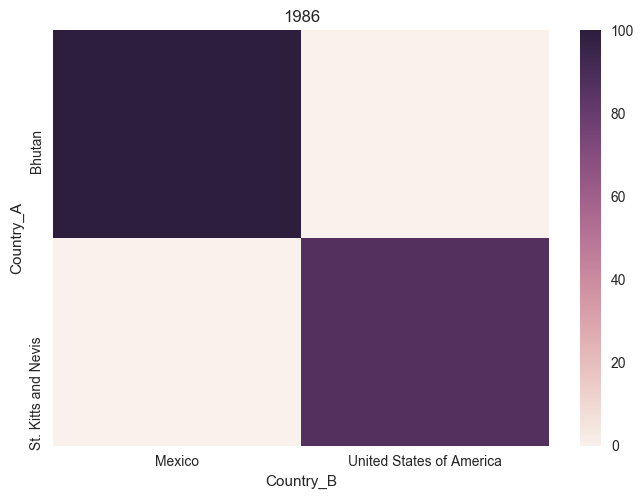

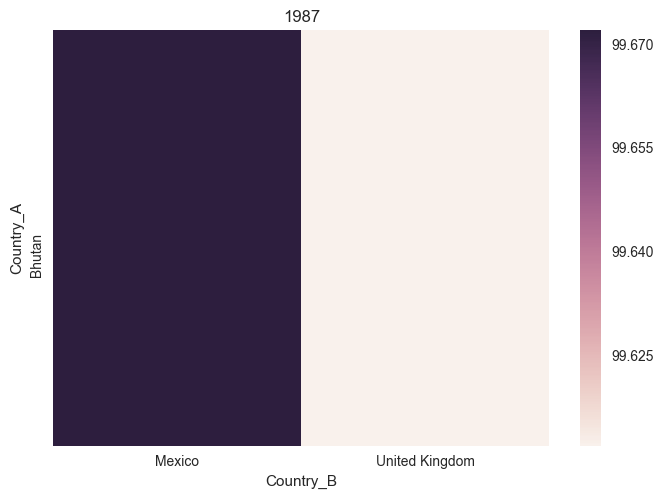

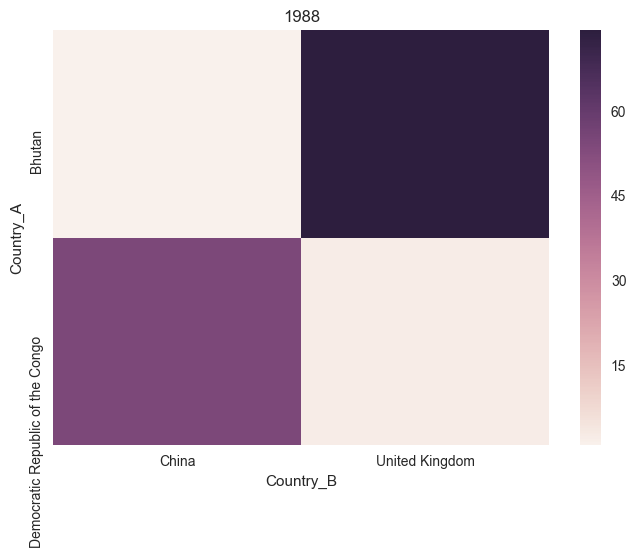

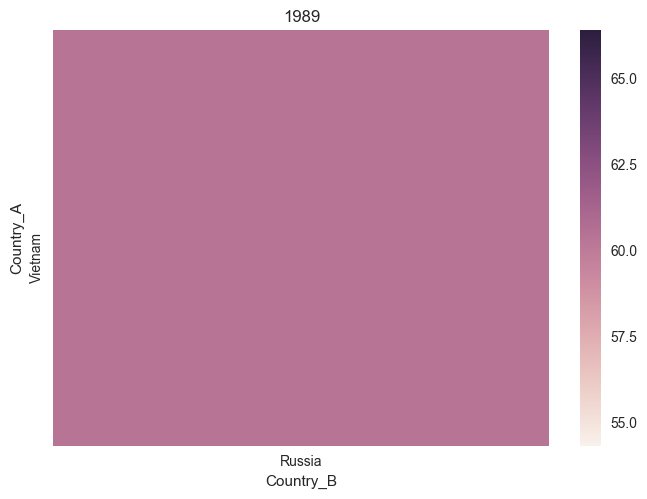

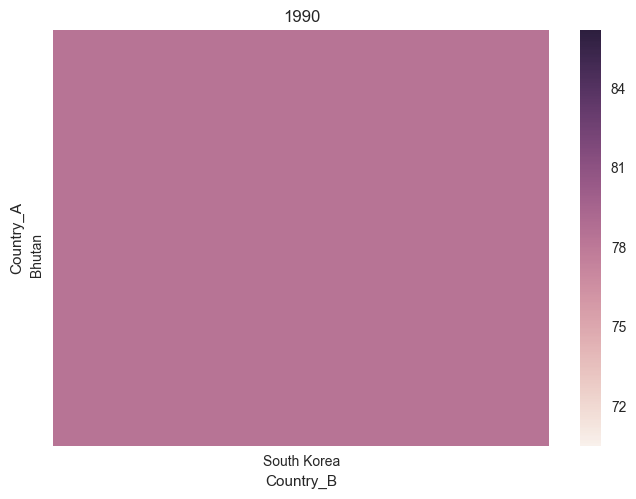

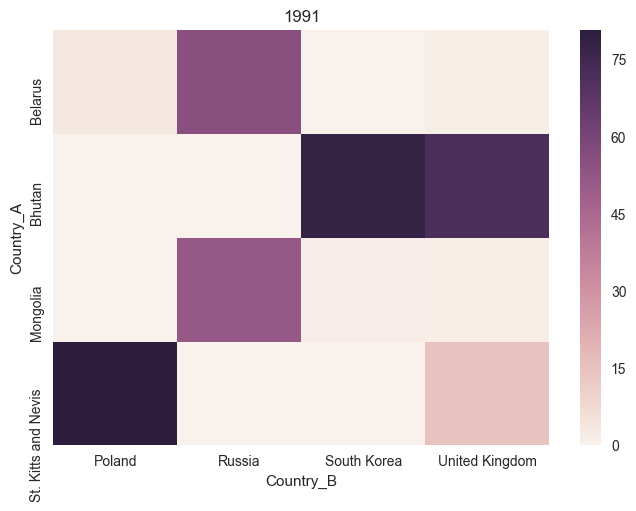

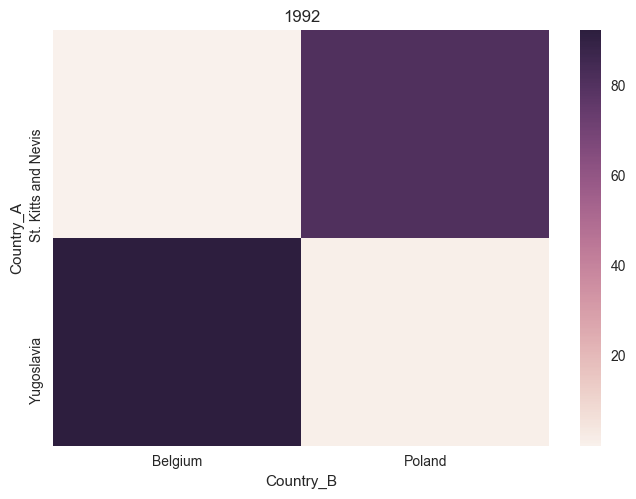

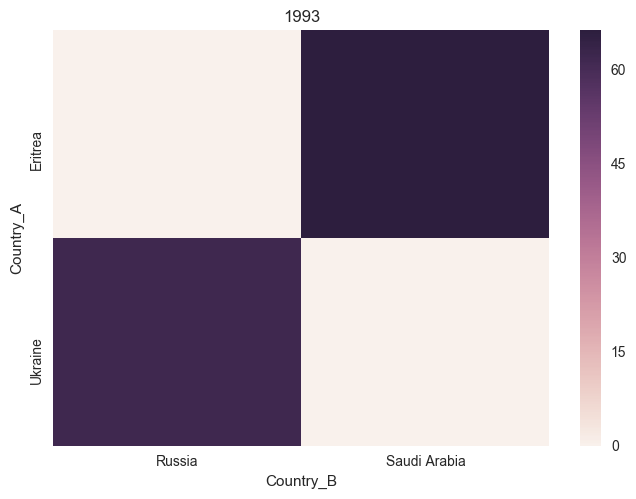

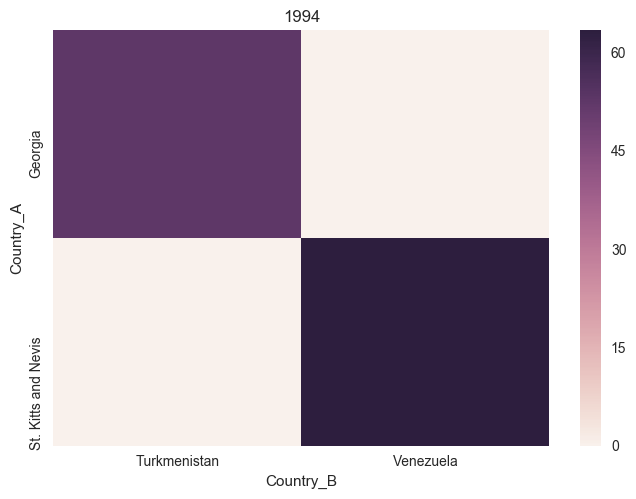

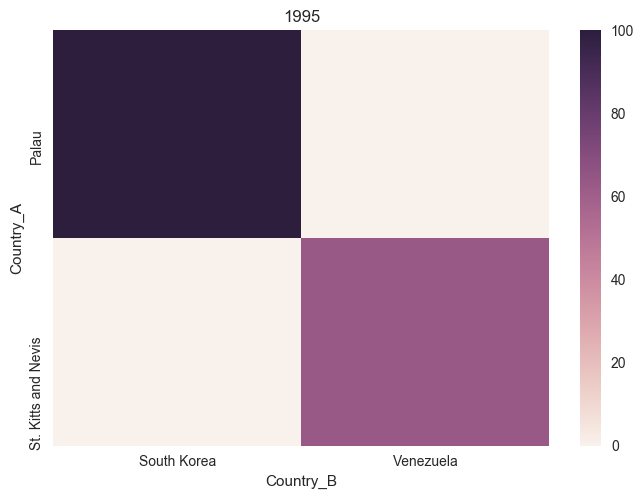

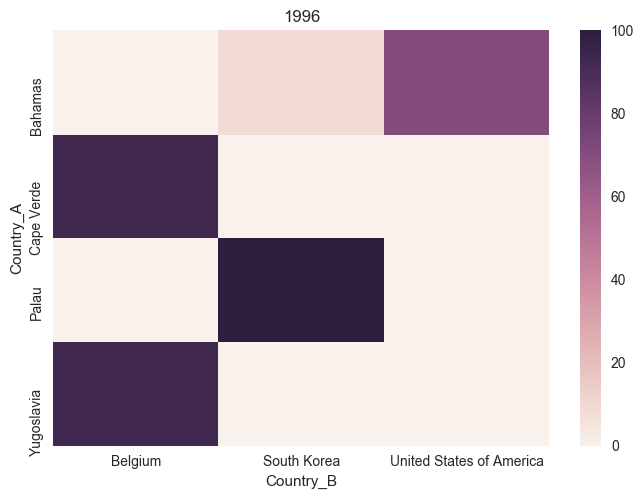

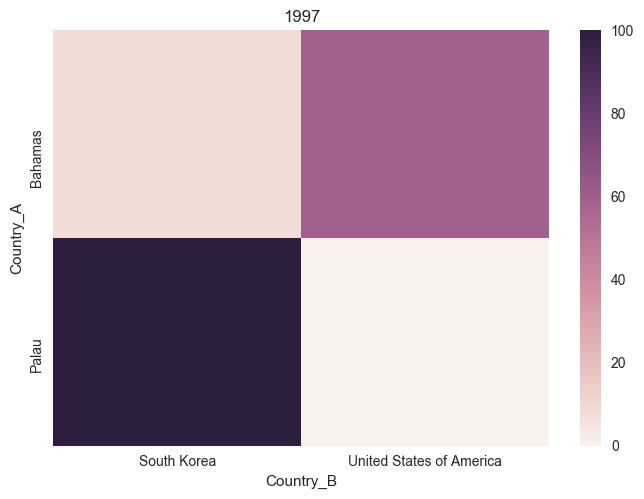

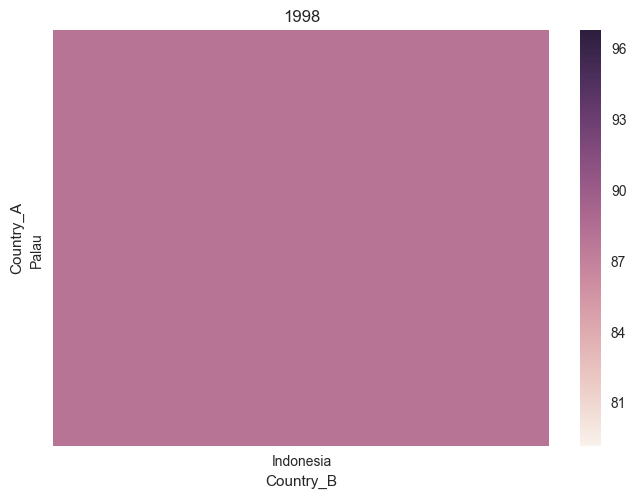

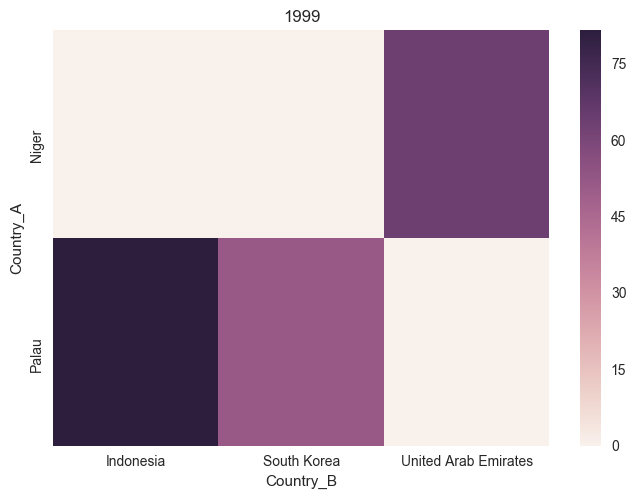

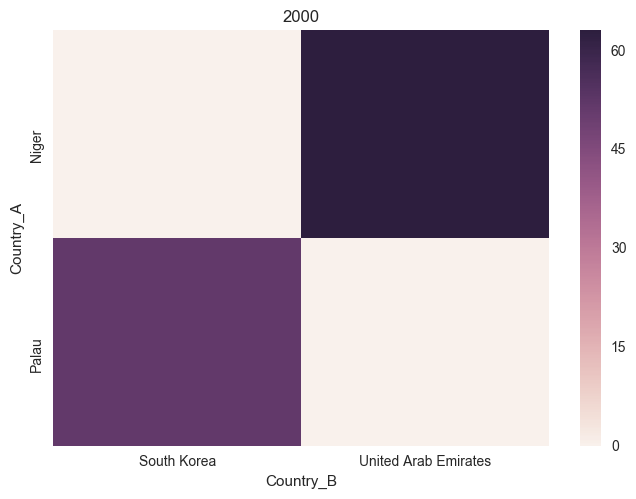

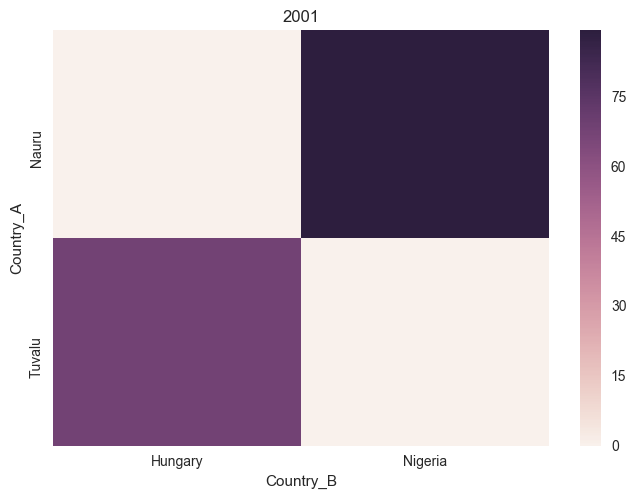

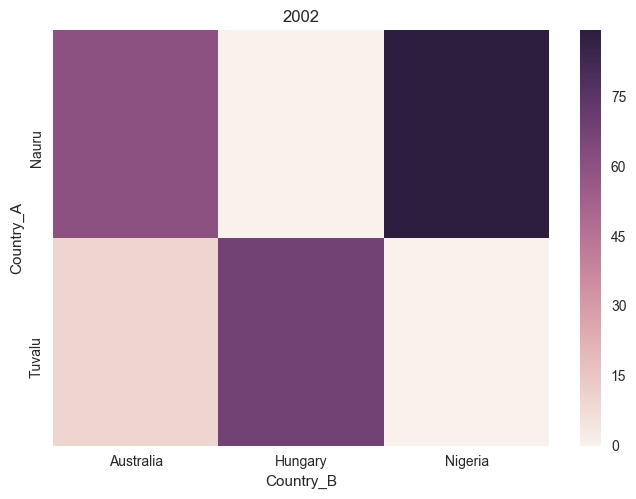

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

<Figure size 800x550 with 0 Axes>

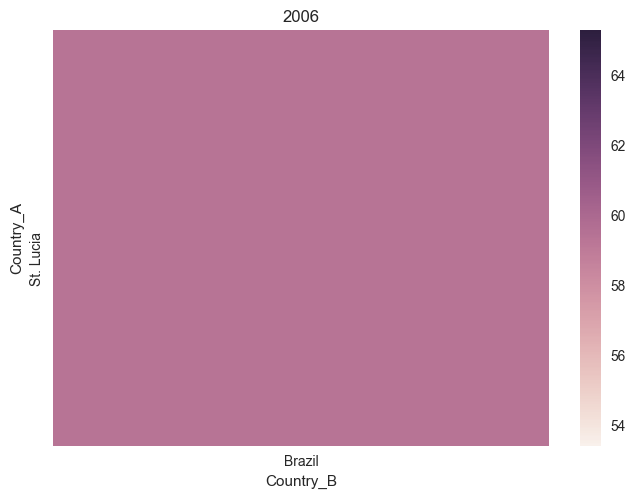

<Figure size 800x550 with 0 Axes>

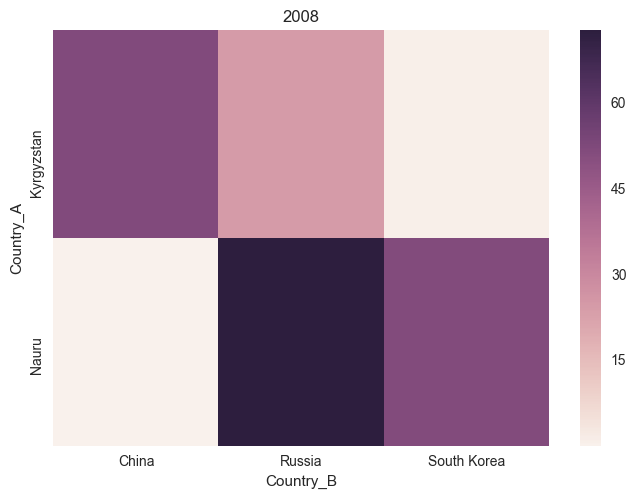

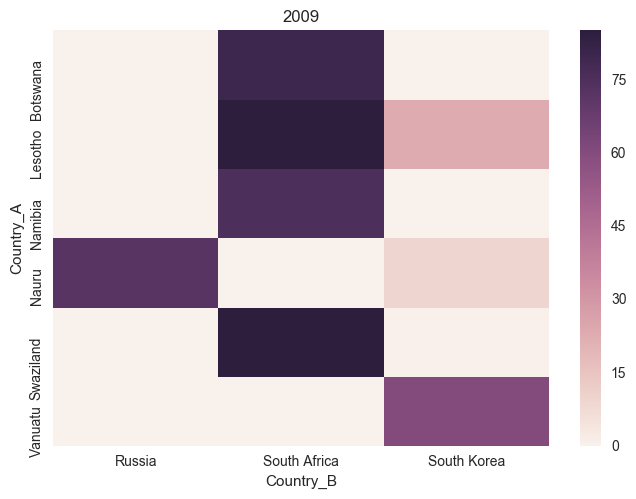

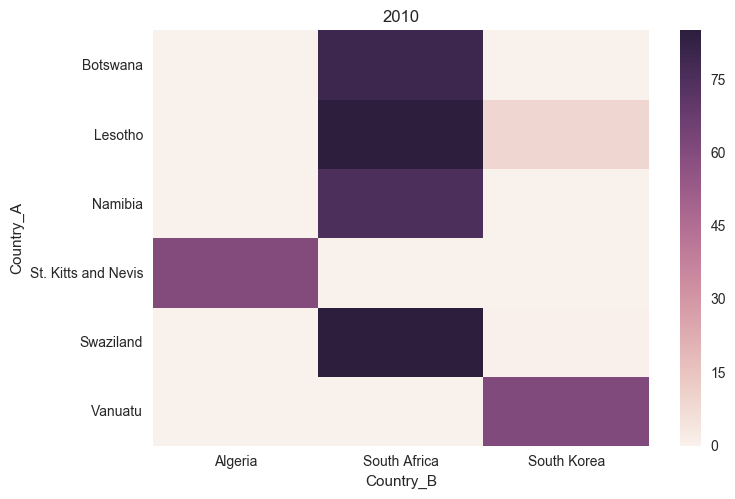

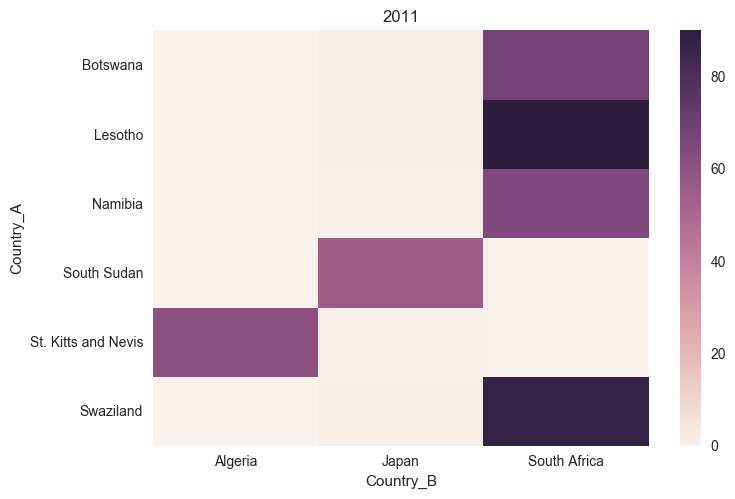

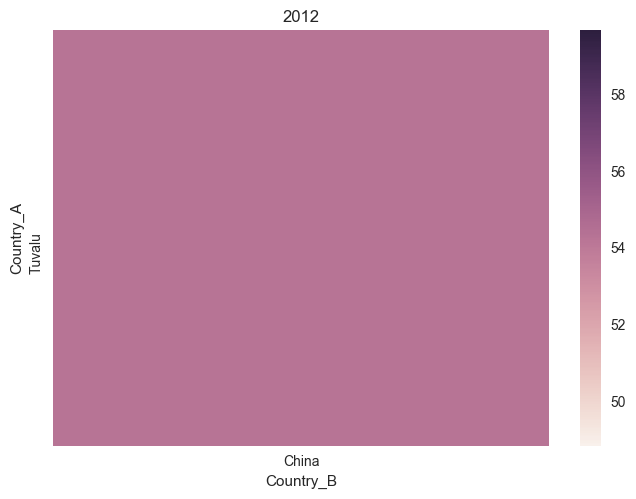

<Figure size 800x550 with 0 Axes>

In [157]:
# Look at the pair of countries which contributed the most to the Frobenius norm of the difference matrix between
# 1991 and 1992.
threshold = 50

diff_frobenius_norm = []
for i in range(len(list_intensity_matrix)-1):
    aligned_mat_left = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[0]
    aligned_mat_right = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[1]
    diff_df = abs(aligned_mat_left - aligned_mat_right)
    # Select rows and columns which have a difference greater than the threshold
    rows_to_keep = np.where((diff_df > threshold).sum(axis=1)>0)[0]
    columns_to_keep = np.where((diff_df > threshold).sum(axis=0)>0)[0]
    try:
        diff_df_reduced = diff_df.iloc[rows_to_keep, columns_to_keep]
        plt.figure()
        sns.heatmap(diff_df_reduced, annot=False).set_title(list(df.year.unique())[:-1][i])
    except:
        continue

The problem of our previous approach is that the norm gets too much noise because when one country enter the dataset, it gets 100 as it starts to exchange with one country, which increases the norm. Therefore, I decided to not take into account new countries when they trade only with one other country.

### Now we can replicate the previous analysis for each continent (to see if they are changes in the exchanges' structure in each continent)

In [20]:
continent = eval(open("continent.py").read())

In [21]:
continent_dict = {}
for i, j in enumerate(continent):
    continent_dict.update({continent[i]['name']: continent[i]['continent']})

In [22]:
countries = list(df.Country_A.unique())

In [23]:
len([i for i in list(map(continent_dict.get, countries)) if i != None])/len(list(map(continent_dict.get, countries)))

0.9128205128205128

On a 88% des pays attachés à un continent en utilisant la méthode du dict. Je vais rajouter les autres à la main...

In [24]:
continent_dict.update({'United States of America': 'North America', 'St. Lucia':'North America','St. Vincent and the Grenadines':'North America',
 'Antigua & Barbuda':'North America', 'St. Kitts and Nevis':'North America', 'Ireland':'Europe', 'Netherlands':'Europe',
 'German Federal Republic':'Europe', 'German Democratic Republic':'Europe', 'Czechoslovakia':'Europe',
 'Yugoslavia':'Europe', 'Kosovo':'Europe', 'Sao Tome and Principe':'Africa','Gambia':'Africa', 'Ivory Coast':'Africa',
 'Congo':'Africa','Zanzibar':'Africa','South Sudan':'Africa', 'Yemen Arab Republic':'Asia',
 'Yemen People\'s Republic':'Asia', 'China':'Asia', 'Taiwan':'Asia', 'Republic of Vietnam':'Asia', 'Brunei':'Asia'})

In [25]:
len([i for i in list(map(continent_dict.get, countries)) if i != None])/len(list(map(continent_dict.get, countries)))

1.0

Maintenant on a un mapping parfait

In [52]:
df['continent'] = list(map(continent_dict.get, df.Country_A))

L'analyse par continent peut maintenant commencer

In [53]:
continents_df = [df[df.continent==i] for i in list(df.continent.unique())]

In [54]:
list(df.continent.unique())

['North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania']

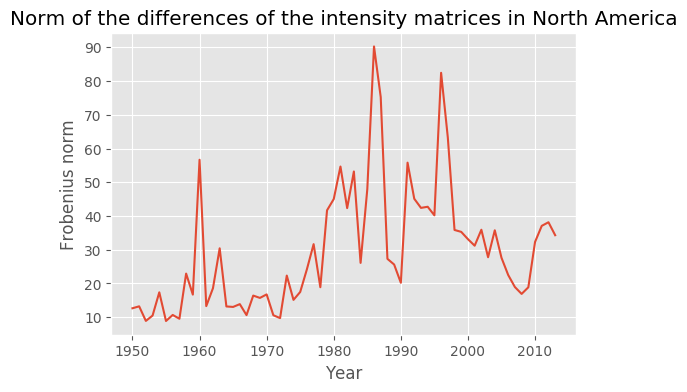

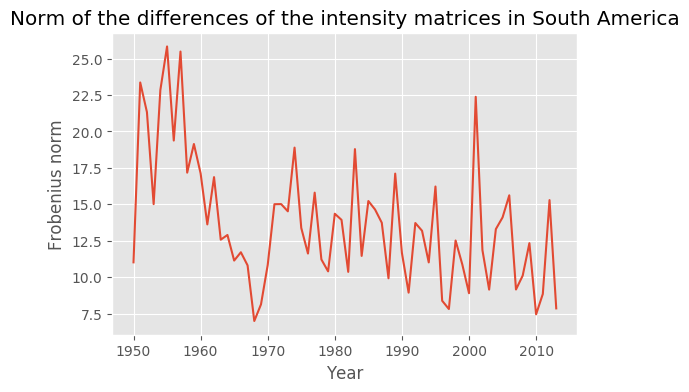

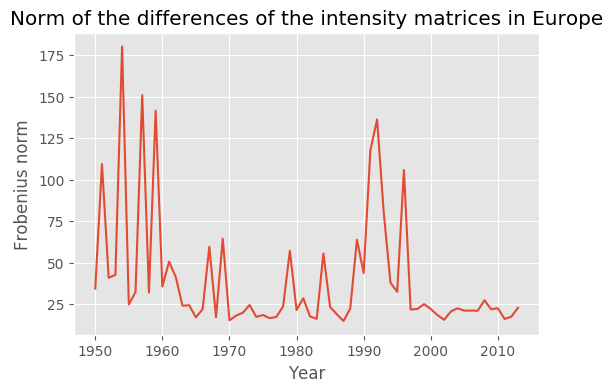

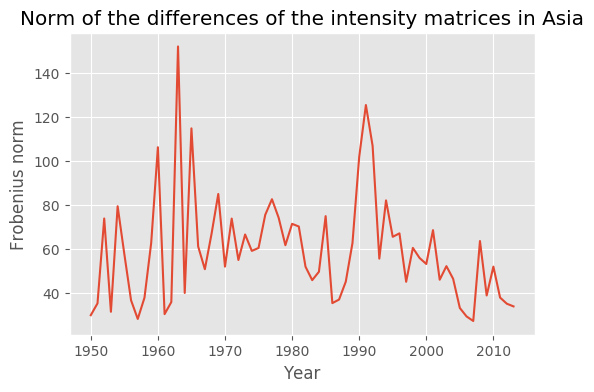

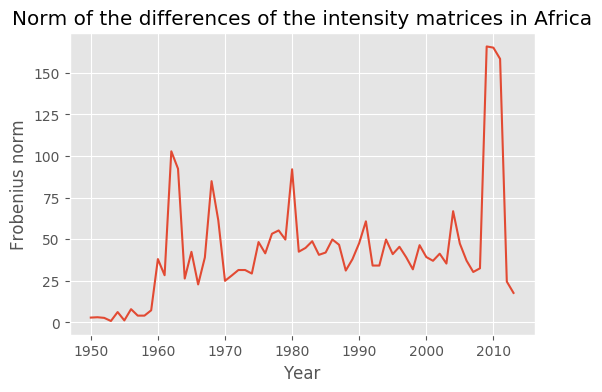

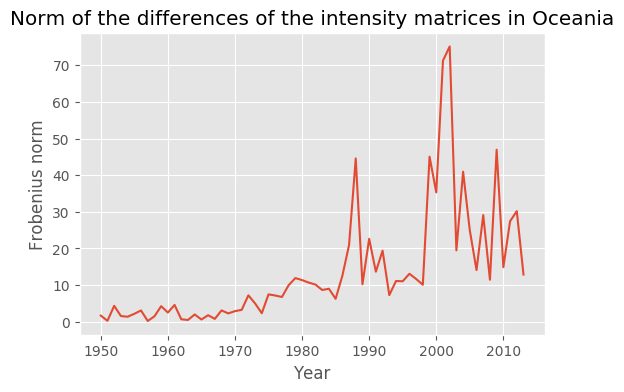

In [59]:
years = list(continents_df[0].year.unique())
for z, data in enumerate(continents_df):
    list_intensity_matrix = []
    for i in years:
        inter_df = data[data.year==i]
        # Get squared similarity matrix
        piv_not_averaged = pd.pivot_table(inter_df, values='flow', index=['Country_A'], columns=['Country_B'], fill_value=0)
        piv_not_averaged = piv_not_averaged.loc[:,piv_not_averaged.index]
        sym_matrix = piv_not_averaged.as_matrix()
        list_intensity_matrix.append(pd.DataFrame(data=sym_matrix, index=piv_not_averaged.columns, columns=piv_not_averaged.columns))
    diff_frobenius_norm = []
    for i in range(len(list_intensity_matrix)-1):
        aligned_mat_left = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[0].as_matrix()
        aligned_mat_right = list_intensity_matrix[i].align(list_intensity_matrix[i+1], join='inner')[1].as_matrix()
        diff_frobenius_norm.append(np.linalg.norm(aligned_mat_left-aligned_mat_right, 'fro'))
    plt.plot(years[:-1], diff_frobenius_norm)
    plt.title('Norm of the differences of the intensity matrices in ' + list(df.continent.unique())[z])
    plt.xlabel('Year')
    plt.ylabel('Frobenius norm')
    plt.show()